# Grid tests with Gaia sources

**Aim of this notebook:** Determine how many Gaia sources down to a certain magnitude limit (14 mag) are located inside the overlapping field regions given a preset overlap.

**Relation to other notebooks:** I am testing the *isolatitudinal grid* that I developed in `Develop_FieldGrid.ipynb`. General tests of this grid (like ensuring no gaps) that do not relate specifically to the specifications of the Pasiphae survey were performed in `Test_FieldGrid.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import Angle, SkyCoord
from astropy.io.votable import parse
from astropy.time import Time
import astropy.units as u
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3

import fieldgrid

## Create initial databases for tests

### Helper classes

In [3]:
class SQLiteConnection:
    """Wrapper class for SQLite connection that allows the use of the
    python with-statement."""

    def __init__(self, db_file):
        """Create SQLiteConnection instance.

        Parameters
        ----------
        db_file : str
            SQLite3 database file name.

        Returns
        -------
        None
        """

        self.db_file = db_file

    def __enter__(self):
        """Open database connection and return it.

        Returns
        -------
        sqlite3.Connection
            Open database connection.
        """

        self.connection = sqlite3.connect(self.db_file)

        return self.connection

    def __exit__(self, type, value, traceback):
        """Close database connection.

        Returns
        -------
        None
        """

        self.connection.close()

In [4]:
class DBConnectorSQLite:
    """SQLite database connector."""

    #--------------------------------------------------------------------------
    def __init__(self, db_file):
        """Create DBConnectorSQLite instance.

        Parameters
        ----------
        db_file : str
            SQLite3 database file name.

        Returns
        -------
        None
        """

        self.db_file = db_file

    #--------------------------------------------------------------------------
    def _query(self, connection, query, many=False, commit=False):
        """Query the database.

        Parameters
        ----------
        connection : sqlite3.Connection
            The database connection.
        query : str
            SQL query.
        many : list, optional
            List of data to add in a single commit. The default is False.
        commit : bool, optional
            Set True to commit to database. The default is False.

        Returns
        -------
        result : sqlite3.Cursor
            Query results.
        """

        cursor = connection.cursor()
        if many is False:
            result = cursor.execute(query)
        else:
            result = cursor.executemany(query, many)

        if commit:
            connection.commit()

        return result
            
    #--------------------------------------------------------------------------   
    def query(self, query, many=False, commit=False):
        
        # add to data base:
        with SQLiteConnection(self.db_file) as connection:

            return self._query(connection, query, many=many, commit=commit).fetchall()
    
    #--------------------------------------------------------------------------
    def create_db(self):
        """Create sqlite3 database.

        Returns
        -------
        None
        """

        create = False

        # check if file exists:
        if os.path.exists(self.db_file):
            answer = input(
                'Database file exists. Overwrite (y) or cancel (enter)?')

            if answer.lower() in ['y', 'yes', 'make it so!']:
                os.system(f'rm {self.db_file}')
                create = True
            else:
                print('Doing nothing.')

        else:
            create = True
            
        if not create:
            return None

        # create file:
        os.system(f'sqlite3 {self.db_file}')

        print(f"Database '{self.db_file}' created.")

        # create tables:
        with SQLiteConnection(self.db_file) as connection:

            # create Fields table:
            query = """\
                CREATE TABLE Fields(
                    field_id integer PRIMARY KEY,
                    center_ra float,
                    center_dec float)
                """
            self._query(connection, query, commit=True)
            print("Table 'Fields' created.")

            # create Sources table:
            query = """\
                CREATE TABLE Sources(
                    source_id integer PRIMARY KEY,
                    gaia_id integer,
                    ra float,
                    dec float,
                    mag float)
                """
            self._query(connection, query, commit=True)
            print("Table 'Sources' created.")

            # create FieldAssoc table:
            query = """\
                CREATE TABLE FieldAssoc(
                    assoc_id integer PRIMARY KEY,
                    source_id integer,
                    field_id integer)
                """
            self._query(connection, query, commit=True)
            print("Table 'FieldAssoc' created.")

            # create OverlappingFields table:
            query = """\
                CREATE TABLE OverlappingFields(
                    pair_id integer PRIMARY KEY,
                    field1_id integer,
                    field2_id integer,
                    n_sources integer)
                """
            self._query(connection, query, commit=True)
            print("Table 'OverlappingFields' created.")
            
    #--------------------------------------------------------------------------   
    def add_fields(self, grid):
        query = """\
            INSERT INTO Fields (
                center_ra, center_dec)
            VALUES (?, ?);
            """
        
        data = [(float(ra), float(dec)) for ra, dec in zip(grid.center_ras, grid.center_decs)]
        
        # add to data base:
        with SQLiteConnection(self.db_file) as connection:
            self._query(connection, query, many=data, commit=True)

        print(f"{len(data)} fields added to data base.")
            
    #--------------------------------------------------------------------------   
    def add_sources(self, data):
        query = """\
            INSERT INTO Sources (
                gaia_id, ra, dec, mag)
            VALUES (?, ?, ?, ?);
            """
        
        # add to data base:
        with SQLiteConnection(self.db_file) as connection:
            self._query(connection, query, many=data, commit=True)

        print(f"{len(data)} sources added to data base.")
            
    #--------------------------------------------------------------------------  
    def n_sources(self):
        query = """\
                SELECT MAX(source_id) FROM Sources;"""
        return self.query(query)[0][0]
            
    #--------------------------------------------------------------------------   
    def add_associations(self, data):
        query = """\
            INSERT INTO FieldAssoc (
                source_id, field_id)
            VALUES (?, ?);
            """
        
        # add to data base:
        with SQLiteConnection(self.db_file) as connection:
            self._query(connection, query, many=data, commit=True)

        print(f"{len(data)} associations added to data base.")
            
    #--------------------------------------------------------------------------   
    def add_overlapping_fields(self, data):
        query = """\
            INSERT INTO OverlappingFields (
                field1_id, field2_id, n_sources)
            VALUES (?, ?, ?);
            """
        
        # add to data base:
        with SQLiteConnection(self.db_file) as connection:
            self._query(connection, query, many=data, commit=True)

        print(f"{len(data)} field pairs added to data base.")
            
    #--------------------------------------------------------------------------  
    def n_fields(self):
        query = """\
                SELECT MAX(field_id) FROM Fields;"""
        return self.query(query)[0][0]

### Set up initial test databases

Create initial databases for the North and South:

In [5]:
db_north = DBConnectorSQLite('gridtests/test_north_init.sqlite3')
db_north.create_db()
db_south = DBConnectorSQLite('gridtests/test_south_init.sqlite3')
db_south.create_db()

Database file exists. Overwrite (y) or cancel (enter)? n


Doing nothing.


Database file exists. Overwrite (y) or cancel (enter)? n


Doing nothing.


Iterate through VOTable files and add sources to database:

In [ ]:
dir_in = 'gaia/'
votable_files = ['mag10_b28', 'mag10-11_b28', 'mag11-12_b28', 'mag12-13_b28', 'mag13-14_b28']

for i, filename in enumerate(votable_files, start=1):
    print(f'VOTable {i}/{len(votable_files)}..')
    print('  Read table..')
    votable = parse(os.path.join(dir_in, f'{filename}.vot'))
    table = votable.get_first_table()
    print('  Parse data..')
    data_n = []
    data_s = []
    for (gaia_id, ra, dec, mag) in zip(
            table.array['source_id'].data, np.radians(table.array['ra'].data),
            np.radians(table.array['dec'].data), table.array['phot_rp_mean_mag'].data):
        if dec >= 0:
            data_n.append((int(gaia_id), ra, dec, float(mag)))
        else:
            data_s.append((int(gaia_id), ra, dec, float(mag)))
    print('  Write to databases..')
    db_north.add_sources(data_n)
    db_south.add_sources(data_s)
    del data_n, data_s

In [6]:
n_sources_n = db_north.n_sources()
n_sources_s = db_south.n_sources()
print(f'Sources North: {n_sources_n:6d}')
print(f'Sources South: {n_sources_s:6d}')
print(f'Total:         {n_sources_n+n_sources_s:6d}')

Sources North: 2305300
Sources South: 2681858
Total:         4987158


## Test setup

### Helper functions

Helper functions to find and store the field associations:

In [5]:
def get_coord(db, id_start, id_stop):
    query = """\
        SELECT ra, dec from Sources
        WHERE source_id >= {0} AND source_id < {1}
        """.format(id_start+1, id_stop+1)
        # Note: SQL counts from 1
    
    results = np.array(db.query(query))
    ra = results[:,0]
    dec = results[:,1]
    
    return ra, dec

In [6]:
def get_associations(tester, sources_ra, sources_dec):
    tester.test(points_ra=sources_ra, points_dec=sources_dec)
    associations = tester.get_results()['field_ids']
    
    return associations

In [7]:
def parse_associations(db, sources_id, associations):
    data = []
    field_pairs = set()

    for source_id, field_ids in zip(sources_id, associations):
        for field_id in field_ids:
            field_id += 1 # SQLite table starts counting with 1
            data.append((int(source_id), int(field_id)))
            
        field_pairs.update(list(combinations(field_ids, 2)))
    
    return data, field_pairs

In [8]:
def count_sources_in_overlap(field1_id, field2_id):
    field1_id += 1 # SQLite table starts counting with 1
    field2_id += 1 # SQLite table starts counting with 1
    query = """\
        SELECT source_id, field_id
        FROM FieldAssoc
        WHERE field_id={0} OR field_id={1};
        """.format(field1_id, field2_id)
    results = db.query(query)
    results = pd.DataFrame(results, columns=('source_id', 'field_id'))
    count = int(np.sum(results.value_counts('source_id').values == 2))
    
    return field1_id, field2_id, count

In [9]:
def run_associations(db, n_batch=10000):
    
    n_batch = int(n_batch)
    n_sources = db.n_sources()
    n_iter = n_sources // n_batch + 1
    print(f'Finding field associations of {n_sources} sources in {n_iter} batches of {n_batch} sources..')
    field_pairs = set()
    
    for i in range(n_iter):
        print(f'Batch {i+1} of {n_iter}..')
        
        # get coordinates of batch of sources:
        i_start = i * n_batch
        i_stop = i_start + n_batch
        sources_ra, sources_dec = get_coord(db, i_start, i_stop)
        sources_id = np.arange(i_start+1, i_stop+1)

        # find associations and save them:
        print('  ', end='')
        associations = get_associations(tester, sources_ra, sources_dec)
        print('  ', end='')
        data, field_pairs_new = parse_associations(db, sources_id, associations)
        field_pairs.update(field_pairs_new)

        # add associations to database:
        db.add_associations(data)
    
    # add overlapping fields to database:
    n_field_pairs = len(field_pairs)
    print(f'Iterate through {n_field_pairs} field pairs to count sources in overlapping region..')
    field_pairs = sorted(field_pairs)
    field_pairs_w_counts = []
    
    for i, (field1_id, field2_id) in enumerate(field_pairs):
        print(f'\r  Field pair {i+1} of {n_field_pairs} ({i*100./n_field_pairs:.0f}%)..', end='')
        field_pairs_w_counts.append(count_sources_in_overlap(field1_id, field2_id))
    
    print('\r  Done.                                             ')
    db.add_overlapping_fields(field_pairs_w_counts)

Helper functions for analysing the results:

In [10]:
def count_sources_in_fields(db):
    query = """\
        SELECT a.field_id, f.center_ra, f.center_dec, a.n_sources
        FROM (
            SELECT field_id, COUNT(source_id) AS n_sources
            FROM FieldAssoc
            GROUP BY field_id) AS a
        LEFT JOIN Fields AS f
        ON a.field_id = f.field_id;
        """
    results = db.query(query)
    results = pd.DataFrame(results, columns=('field_id', 'field_ra', 'field_dec', 'n_sources'))

    return results

In [11]:
def get_overlapping_fields(db):
    query = """\
        SELECT j.field1_id, j.field2_id, j.n_sources, j.field1_ra, j.field1_dec, f2.center_ra AS field2_ra, f2.center_dec AS field2_dec
        FROM (
            SELECT o.field1_id, o.field2_id, o.n_sources, f1.center_ra AS field1_ra, f1.center_dec AS field1_dec
            FROM OverlappingFields AS o
            LEFT JOIN Fields AS f1
            ON o.field1_id = f1.field_id) AS j
        JOIN Fields AS f2
        ON j.field2_id = f2.field_id;
        """
    results = db.query(query)
    results = pd.DataFrame(results, columns=('field1_id', 'field2_id', 'n_sources', 'field1_ra', 'field1_dec', 'field2_ra', 'field2_dec'))
    results['delta_ra'] = results['field2_ra'] - results['field1_ra']
    results['delta_dec'] = results['field2_dec'] - results['field1_dec']
    results['same_dec'] = np.isclose(results['delta_dec'], 0)
    declinations = results['field1_dec'].unique()
    field1_dec_id = np.ones(results.shape[0], dtype=int)
    field2_dec_id = np.ones(results.shape[0], dtype=int)

    for i, dec in enumerate(declinations):
        sel = results['field1_dec'] == dec
        field1_dec_id[sel] = i
        sel = results['field2_dec'] == dec
        field2_dec_id[sel] = i

    results.insert(5, 'field1_dec_id', field1_dec_id)
    results.insert(8, 'field2_dec_id', field2_dec_id)
    del declinations, field1_dec_id, field2_dec_id

    return results

### Test source-field-association code

Test my code with fewer sources and a coarse grid:

In [16]:
db_north = DBConnectorSQLite('gridtests/test_init.sqlite3')
db_north.create_db()

Database file exists. Overwrite (y) or cancel (enter)? y


Database 'gridtests/test_init.sqlite3' created.
Table 'Fields' created.
Table 'Sources' created.
Table 'FieldAssoc' created.
Table 'OverlappingFields' created.


In [17]:
dir_in = 'gaia/'
votable_files = ['mag10_b28', 'mag10-11_b28']

for i, filename in enumerate(votable_files, start=1):
    print(f'VOTable {i}/{len(votable_files)}..')
    print('  Read table..')
    votable = parse(os.path.join(dir_in, f'{filename}.vot'))
    table = votable.get_first_table()
    print('  Parse data..')
    data_n = []
    for (gaia_id, ra, dec, mag) in zip(
            table.array['source_id'].data, np.radians(table.array['ra'].data),
            np.radians(table.array['dec'].data), table.array['phot_rp_mean_mag'].data):
        if dec >= 0:
            data_n.append((int(gaia_id), ra, dec, float(mag)))
        else:
            pass
    print('  Write to databases..')
    db_north.add_sources(data_n)
    del data_n

VOTable 1/2..
  Read table..
  Parse data..
  Write to databases..
120299 sources added to data base.
VOTable 2/2..
  Read table..
  Parse data..
  Write to databases..
144501 sources added to data base.


In [19]:
fov = Angle(5. * u.deg)
overlap = Angle(1. * u.deg)
tilt = Angle(0.* u.deg)
dec_lim_north = Angle(90. * u.deg)
dec_lim_south = Angle(0. * u.deg)
gal_lat_lim = Angle(30. * u.deg)
gal_lat_lim_strict = True
verbose = 1

grid = fieldgrid.FieldGridIsoLat(
        fov.rad, overlap=overlap.rad, tilt=tilt.rad, dec_lim_north=dec_lim_north.rad, dec_lim_south=dec_lim_south.rad,
        gal_lat_lim=gal_lat_lim.rad, gal_lat_lim_strict=gal_lat_lim_strict, 
        verbose=verbose)

Create fields..
  Calculate field centers..
  Calculate field corners..
    Done                                                    
  Identify fields in Galactic plane..
Final number of fields: 720


In [20]:
tester = fieldgrid.FieldGridTester(grid)

In [21]:
db_file = 'test.sqlite3'
os.system(f'cp gridtests/test_init.sqlite3 gridtests/{db_file}')
db = DBConnectorSQLite(os.path.join('gridtests/', db_file))
db.add_fields(grid)
run_associations(db, n_batch=150000)

720 fields added to data base.
Finding field associations of 264800 sources in 2 batches of 150000 sources..
Batch 1 of 2..
  Identify test point field associations..
  Done.                                          
  230286 associations added to data base.
Batch 2 of 2..
  Identify test point field associations..
  Done.                                          
  175944 associations added to data base.
Iterate through 2376 field pairs to count sources in overlapping region..
  Done.                                             
2376 field pairs added to data base.


### Test analysis

In [ ]:
db = DBConnectorSQLite('gridtests/test.sqlite3')

In [ ]:
counts = count_sources_in_fields(db)
sns.histplot(data=counts, x='n_sources', discrete=True)
counts['n_sources'].describe()

In [ ]:
overlapping_fields = get_overlapping_fields(db)
overlapping_fields

Distribution of number of sources in overlapping regions:

In [ ]:
sns.histplot(data=overlapping_fields, x='n_sources', hue='same_dec', discrete=True);

In [ ]:
sel = overlapping_fields['same_dec']
n_sources_grouped = overlapping_fields.loc[sel, ('field1_dec_id', 'field1_dec', 'n_sources')].groupby(by='field1_dec_id')
n_sources = n_sources_grouped.min()
n_sources = n_sources.reset_index(drop=True).rename(columns={'n_sources': 'n_sources_min'})
n_sources.insert(
        2, 'n_sources_median', 
        n_sources_grouped.median()['n_sources'])
n_sources.insert(
        3, 'n_sources_mean', 
        n_sources_grouped.mean()['n_sources'])
n_sources.insert(
        4, 'n_sources_std', 
        n_sources_grouped.std()['n_sources'])
n_sources.insert(
        5, 'n_sources_max', 
        n_sources_grouped.max()['n_sources'])
#plt.errorbar(np.degrees(n_sources['field1_dec']), n_sources['n_sources_mean'], yerr=n_sources['n_sources_std'])
#plt.ylabel('Mean count')
#plt.xlabel('Declination (deg)');
sns.scatterplot(data=n_sources, x='field1_dec', y='n_sources_min', marker='_', label='min')
sns.scatterplot(data=n_sources, x='field1_dec', y='n_sources_max', marker='_', label='max')
sns.scatterplot(data=n_sources, x='field1_dec', y='n_sources_median', marker='o', label='median')

In [ ]:
sel = overlapping_fields['same_dec']
sns.boxplot(data=overlapping_fields.loc[sel], x='field1_dec', y='n_sources', whis=10)

## Test Northern Grid

### Overlap: 0 arcmin

In [62]:
fov = Angle(30. * u.arcmin)
overlap = Angle(0. * u.arcmin)
tilt = Angle(0.* u.deg)
dec_lim_north = Angle(90. * u.deg)
dec_lim_south = Angle(0. * u.deg)
gal_lat_lim = Angle(30. * u.deg)
gal_lat_lim_strict = True
verbose = 1

grid = fieldgrid.FieldGridIsoLat(
        fov.rad, overlap=overlap.rad, tilt=tilt.rad, dec_lim_north=dec_lim_north.rad, dec_lim_south=dec_lim_south.rad,
        gal_lat_lim=gal_lat_lim.rad, gal_lat_lim_strict=gal_lat_lim_strict, 
        verbose=verbose)

Create fields..
  Calculate field centers..
  Calculate field corners..
    Done                                                    
  Identify fields in Galactic plane..
Final number of fields: 41835


In [ ]:
tester = fieldgrid.FieldGridTester(grid)

In [ ]:
hemisphere = 'north'
run = False

In [ ]:
if run:
    db_file = f'test_{hemisphere}_{overlap.arcmin:.1f}arcmin.sqlite3'
    os.system(f'cp gridtests/test_{hemisphere}_init.sqlite3 gridtests/{db_file}')
    db = DBConnectorSQLite(os.path.join('gridtests/', db_file))
    db.add_fields(grid)
    time_start = Time.now()
    print('Starting calculations at', time_start)
    run_associations(db, n_batch=500000)
    time_total = Time.now() - time_start
    print(f'Finished after {time_total.value*24.} hours')

### Overlap: 2 arcmin

In [ ]:
fov = Angle(30. * u.arcmin)
overlap = Angle(2. * u.arcmin)
tilt = Angle(0.* u.deg)
dec_lim_north = Angle(90. * u.deg)
dec_lim_south = Angle(0. * u.deg)
gal_lat_lim = Angle(30. * u.deg)
gal_lat_lim_strict = True
verbose = 1

grid = fieldgrid.FieldGridIsoLat(
        fov.rad, overlap=overlap.rad, tilt=tilt.rad, dec_lim_north=dec_lim_north.rad, dec_lim_south=dec_lim_south.rad,
        gal_lat_lim=gal_lat_lim.rad, gal_lat_lim_strict=gal_lat_lim_strict, 
        verbose=verbose)

In [ ]:
tester = fieldgrid.FieldGridTester(grid)

In [ ]:
hemisphere = 'north'
run = False

In [ ]:
if run:
    db_file = f'test_{hemisphere}_{overlap.arcmin:.1f}arcmin.sqlite3'
    os.system(f'cp gridtests/test_{hemisphere}_init.sqlite3 gridtests/{db_file}')
    db = DBConnectorSQLite(os.path.join('gridtests/', db_file))
    db.add_fields(grid)
    time_start = Time.now()
    print('Starting calculations at', time_start)
    run_associations(db, n_batch=500000)
    time_total = Time.now() - time_start
    print(f'Finished after {time_total.value*24.} hours')

#### Results

In [57]:
hemisphere = 'north'
overlap = Angle(2. * u.arcmin)

db_file = f'gridtests/test_{hemisphere}_{overlap.arcmin:.1f}arcmin.sqlite3'
db = DBConnectorSQLite(db_file)

In [59]:
print(f'Sources: {db.n_sources():8d}')
print(f'Fields: {db.n_fields():8d}')

Sources:  2305300
Fields:    47834


##### How many stars are in each field?

count    47834.000000
mean        50.730108
std         18.946283
min         12.000000
25%         37.000000
50%         47.000000
75%         61.000000
max        674.000000
Name: n_sources, dtype: float64

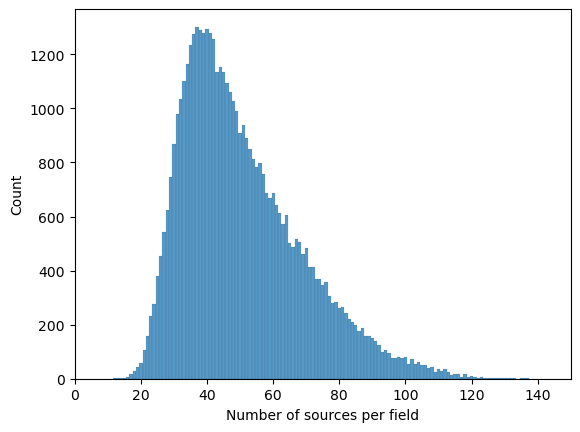

In [42]:
counts = count_sources_in_fields(db)
ax = sns.histplot(data=counts, x='n_sources', discrete=True)
ax.set(xlim=(0, 150), xlabel='Number of sources per field')
counts['n_sources'].describe()

##### How many stars are in one field depending on declination?

In [43]:
counts_grouped = counts.groupby(by='field_dec')
counts_per_dec = counts_grouped.min()
counts_per_dec = counts_per_dec.reset_index().rename(columns={'n_sources': 'n_sources_min'}).loc[:, ('field_dec', 'n_sources_min')]
counts_per_dec.insert(
        2, 'n_sources_median', 
        counts_grouped.median()['n_sources'].values)
counts_per_dec.insert(
        3, 'n_sources_mean', 
        counts_grouped.mean()['n_sources'].values)
counts_per_dec.insert(
        4, 'n_sources_std', 
        counts_grouped.std()['n_sources'].values)
counts_per_dec.insert(
        5, 'n_sources_max', 
        counts_grouped.max()['n_sources'].values)
counts_per_dec.insert(
        2, 'field_dec_deg', 
        np.degrees(counts_per_dec['field_dec'].values))

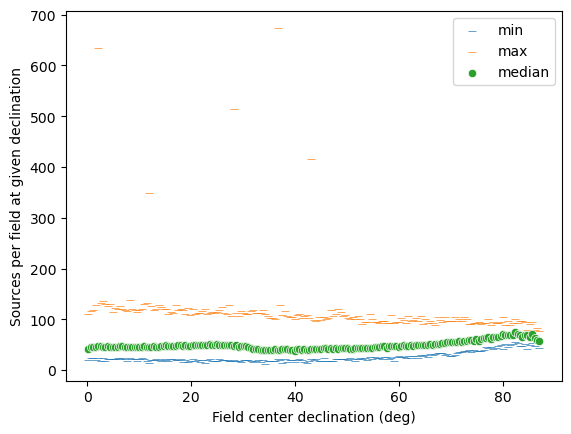

In [44]:
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_median', marker='o', label='median')
ax.set(xlabel='Field center declination (deg)', ylabel='Sources per field at given declination');

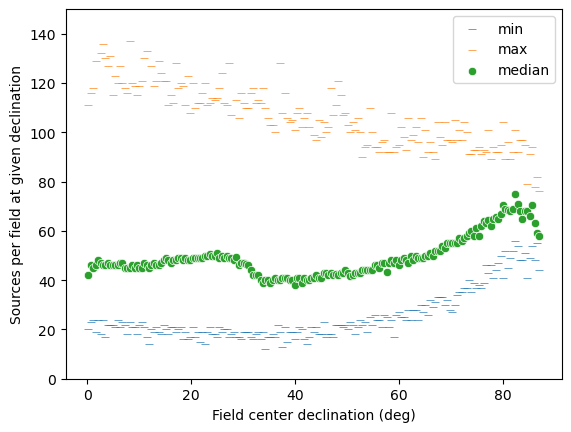

In [45]:
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec_deg', y='n_sources_median', marker='o', label='median')
ax.set(xlabel='Field center declination (deg)', ylabel='Sources per field at given declination', ylim=(0, 150));

##### How many stars are in the overlapping regions?

In [46]:
overlapping_fields = get_overlapping_fields(db)
overlapping_fields

,field1_id,field2_id,n_sources,field1_ra,field1_dec,field1_dec_id,field2_ra,field2_dec,field2_dec_id,delta_ra,delta_dec,same_dec
0,1,2,2,0.000000,0.003491,0,0.008149,0.003491,0,0.008149,0.000000,True
1,1,481,0,0.000000,0.003491,0,6.275036,0.003491,0,6.275036,0.000000,True
2,1,482,6,0.000000,0.003491,0,0.000000,0.011636,1,0.000000,0.008145,False
3,2,3,3,0.008149,0.003491,0,0.016299,0.003491,0,0.008149,0.000000,True
4,2,483,0,0.008149,0.003491,0,0.008149,0.011636,1,0.000000,0.008145,False
...,...,...,...,...,...,...,...,...,...,...,...,...
113573,47829,47830,2,3.064968,1.518436,186,3.218217,1.518436,186,0.153248,0.000000,True
113574,47830,47831,1,3.218217,1.518436,186,3.371465,1.518436,186,0.153248,0.000000,True
113575,47831,47832,8,3.371465,1.518436,186,3.524714,1.518436,186,0.153248,0.000000,True
113576,47832,47833,5,3.524714,1.518436,186,3.677962,1.518436,186,0.153248,0.000000,True


Distribution of number of sources in overlapping regions:

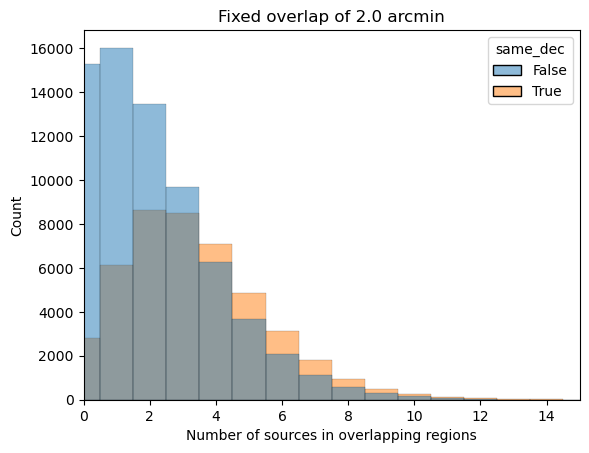

In [51]:
ax = sns.histplot(data=overlapping_fields, x='n_sources', hue='same_dec', discrete=True)
ax.set(xlabel='Number of sources in overlapping regions', title=f'Fixed overlap of {overlap.arcmin} arcmin', xlim=(0, 15));

In [50]:
print('Same declination:')
sel = overlapping_fields['same_dec']
print(overlapping_fields.loc[sel, 'n_sources'].describe())

print('\nDifferent declination:')
overlapping_fields.loc[~sel, 'n_sources'].describe()

Same declination:
count    44903.000000
mean         3.360110
std          2.563613
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        289.000000
Name: n_sources, dtype: float64

Different declination:


count    68675.000000
mean         2.120903
std          1.963315
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         74.000000
Name: n_sources, dtype: float64

### Overlap: 10 arcmin

In [12]:
fov = Angle(30. * u.arcmin)
overlap = Angle(10. * u.arcmin)
tilt = Angle(0.* u.deg)
dec_lim_north = Angle(90. * u.deg)
dec_lim_south = Angle(0. * u.deg)
gal_lat_lim = Angle(30. * u.deg)
gal_lat_lim_strict = True
verbose = 1

grid = fieldgrid.FieldGridIsoLat(
        fov.rad, overlap=overlap.rad, tilt=tilt.rad, dec_lim_north=dec_lim_north.rad, dec_lim_south=dec_lim_south.rad,
        gal_lat_lim=gal_lat_lim.rad, gal_lat_lim_strict=gal_lat_lim_strict, 
        verbose=verbose)

Create fields..
  Calculate field centers..
  Calculate field corners..
    Done                                                    
  Identify fields in Galactic plane..
Final number of fields: 93629


In [13]:
tester = fieldgrid.FieldGridTester(grid)

In [14]:
hemisphere = 'north'
run = False

In [15]:
if run:
    db_file = f'test_{hemisphere}_{overlap.arcmin:.1f}arcmin.sqlite3'
    os.system(f'cp gridtests/test_{hemisphere}_init.sqlite3 gridtests/{db_file}')
    db = DBConnectorSQLite(os.path.join('gridtests/', db_file))
    db.add_fields(grid)
    time_start = Time.now()
    print('Starting calculations at', time_start)
    run_associations(db, n_batch=500000)
    time_total = Time.now() - time_start
    print(f'Finished after {time_total.value*24.} hours')

93629 fields added to data base.
Starting calculations at 2023-05-07 10:25:06.456640
Finding field associations of 2305300 sources in 5 batches of 500000 sources..
Batch 1 of 5..
  Identify test point field associations..
  Done.                                          
  1034381 associations added to data base.
Batch 2 of 5..
  Identify test point field associations..
  Done.                                          
  1026544 associations added to data base.
Batch 3 of 5..
  Identify test point field associations..
  Done.                                          
  1016972 associations added to data base.
Batch 4 of 5..
  Identify test point field associations..
  Done.                                          
  1034219 associations added to data base.
Batch 5 of 5..
  Identify test point field associations..
  Done.                                          
  638148 associations added to data base.
Iterate through 356521 field pairs to count sources in overlapping region..
  Done

#### Results

In [60]:
hemisphere = 'north'
overlap = Angle(10. * u.arcmin)

db_file = f'gridtests/test_{hemisphere}_{overlap.arcmin:.1f}arcmin.sqlite3'
db = DBConnectorSQLite(db_file)

In [61]:
print(f'Sources: {db.n_sources():8d}')
print(f'Fields: {db.n_fields():8d}')

Sources:  2305300
Fields:    93629


##### How many stars are in each field?

Get source counts per field from database, also get Galactic coordinates of field centers, convert all coordinates to degrees for simpler plotting:

In [74]:
counts = count_sources_in_fields(db)
counts['field_ra'] = np.degrees(counts['field_ra'])
counts['field_dec'] = np.degrees(counts['field_dec'])

# transform to Galactic coordinates:
coords = SkyCoord(ra=counts['field_ra']*u.deg, dec=counts['field_dec']*u.deg, frame='icrs')
counts.insert(3, 'field_l', coords.galactic.l.deg)
counts.insert(4, 'field_b', coords.galactic.b.deg)
del coords

In [147]:
sel = np.logical_and(counts['field_b'] < 30., counts['field_b'] > -30.)
counts.loc[sel]

,field_id,field_ra,field_dec,field_l,field_b,n_sources
206,207,68.730306,0.166667,195.594059,-29.868341,61
207,208,136.793327,0.166667,229.824374,29.877490,56
543,544,248.897127,0.166667,16.022242,29.901760,95
544,545,316.960148,0.166667,50.252458,-29.844127,109
878,879,68.396664,0.500000,195.063976,-29.974884,85
...,...,...,...,...,...,...
93624,93625,190.188679,87.166667,123.084250,29.958425,74
93625,93626,196.981132,87.166667,122.696981,29.954061,77
93626,93627,203.773585,87.166667,122.313287,29.908974,83
93627,93628,210.566038,87.166667,121.938992,29.823852,76


##### How many stars are in one field depending on declination?

In [76]:
counts_grouped = counts.groupby(by='field_dec')
counts_per_dec = counts_grouped.min()
counts_per_dec = counts_per_dec.reset_index().rename(columns={'n_sources': 'n_sources_min'}).loc[:, ('field_dec', 'n_sources_min')]
counts_per_dec.insert(
        2, 'n_sources_median', 
        counts_grouped.median()['n_sources'].values)
counts_per_dec.insert(
        3, 'n_sources_mean', 
        counts_grouped.mean()['n_sources'].values)
counts_per_dec.insert(
        4, 'n_sources_std', 
        counts_grouped.std()['n_sources'].values)
counts_per_dec.insert(
        5, 'n_sources_max', 
        counts_grouped.max()['n_sources'].values)

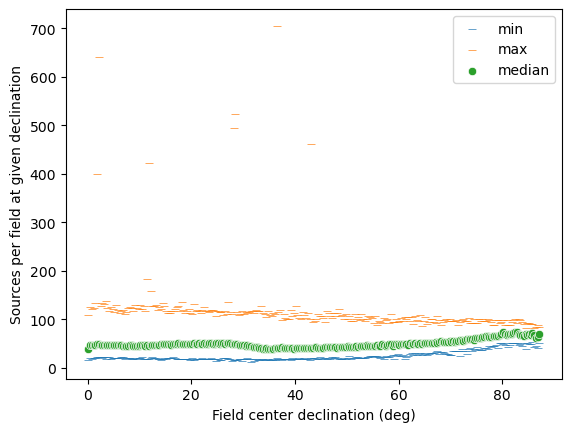

In [79]:
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_median', marker='o', label='median')
ax.set(xlabel='Field center declination (deg)', ylabel='Sources per field at given declination');

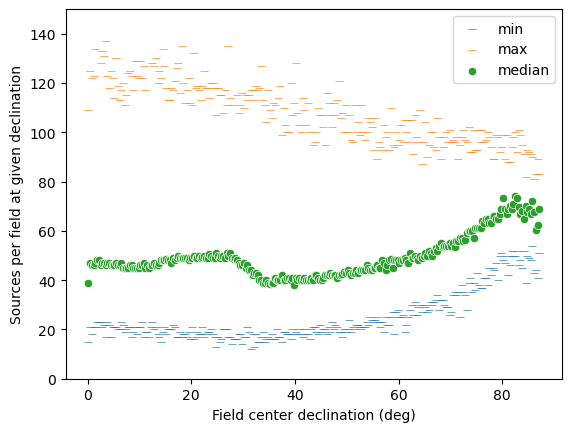

In [80]:
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_dec, x='field_dec', y='n_sources_median', marker='o', label='median')
ax.set(xlabel='Field center declination (deg)', ylabel='Sources per field at given declination', ylim=(0, 150));

##### How many stars are in one field depending on Galactic latitude?

In [158]:
bin_size = 2
bins = np.arange(np.ceil(counts['field_b'].max()), np.floor(counts['field_b'].min())-bin_size, -bin_size)[::-1]
bin_centers = (bins[0:-1] + bins[1:]) / 2

In [159]:
counts_grouped = counts.groupby(by=pd.cut(counts['field_b'], bins=bins))
counts_per_b = counts_grouped.min()
counts_per_b = counts_per_b.reset_index(drop=True).rename(columns={'n_sources': 'n_sources_min'}).loc[:, ('n_sources_min', )]
counts_per_b.insert(0, 'b_bin_center', bin_centers)
counts_per_b.insert(
        2, 'n_sources_median', 
        counts_grouped.median()['n_sources'].values)
counts_per_b.insert(
        3, 'n_sources_mean', 
        counts_grouped.mean()['n_sources'].values)
counts_per_b.insert(
        4, 'n_sources_std', 
        counts_grouped.std()['n_sources'].values)
counts_per_b.insert(
        5, 'n_sources_max', 
        counts_grouped.max()['n_sources'].values)

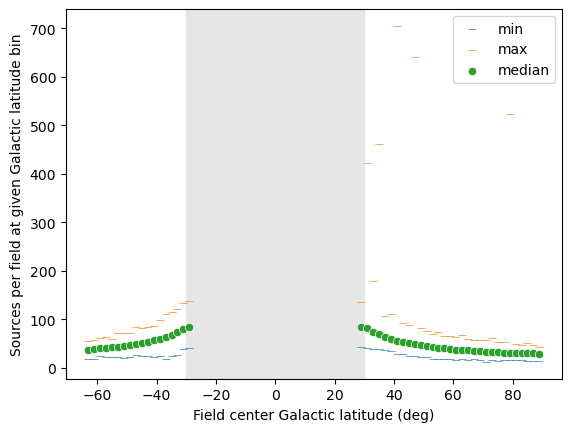

In [160]:
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per field at given Galactic latitude bin');

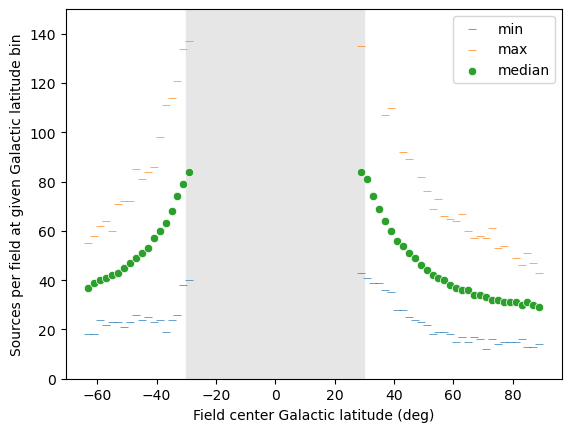

In [161]:
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=counts_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per field at given Galactic latitude bin', ylim=(0, 150));

##### How many stars are in the overlapping regions?

Get source counts per overlapping field pair from database, also get Galactic coordinates of field centers for first field, convert all coordinates to degrees for simpler plotting:

In [164]:
overlapping_fields = get_overlapping_fields(db)
overlapping_fields['field1_ra'] = np.degrees(overlapping_fields['field1_ra'])
overlapping_fields['field1_dec'] = np.degrees(overlapping_fields['field1_dec'])
overlapping_fields['field2_ra'] = np.degrees(overlapping_fields['field2_ra'])
overlapping_fields['field2_dec'] = np.degrees(overlapping_fields['field2_dec'])

# transform to Galactic coordinates:
coords = SkyCoord(ra=overlapping_fields['field1_ra']*u.deg, dec=overlapping_fields['field1_dec']*u.deg, frame='icrs')
overlapping_fields.insert(5, 'field1_l', coords.galactic.l.deg)
overlapping_fields.insert(6, 'field1_b', coords.galactic.b.deg)
del coords

overlapping_fields

,field1_id,field2_id,n_sources,field1_ra,field1_dec,field1_l,field1_b,field1_dec_id,field2_ra,field2_dec,field2_dec_id,delta_ra,delta_dec,same_dec
0,1,2,14,0.000000,0.166667,96.470235,-60.035618,0,0.333642,0.166667,0,0.005823,0.000000,True
1,1,673,14,0.000000,0.166667,96.470235,-60.035618,0,359.666358,0.166667,0,6.277362,0.000000,True
2,1,674,14,0.000000,0.166667,96.470235,-60.035618,0,0.000000,0.500000,1,0.000000,0.005818,False
3,1,675,5,0.000000,0.166667,96.470235,-60.035618,0,0.333642,0.500000,1,0.005823,0.005818,False
4,1,1348,6,0.000000,0.166667,96.470235,-60.035618,0,359.666358,0.500000,1,6.277362,0.005818,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356516,93624,93625,22,183.396226,87.166667,123.469201,29.922000,261,190.188679,87.166667,261,0.118551,0.000000,True
356517,93625,93626,24,190.188679,87.166667,123.084250,29.958425,261,196.981132,87.166667,261,0.118551,0.000000,True
356518,93626,93627,26,196.981132,87.166667,122.696981,29.954061,261,203.773585,87.166667,261,0.118551,0.000000,True
356519,93627,93628,31,203.773585,87.166667,122.313287,29.908974,261,210.566038,87.166667,261,0.118551,0.000000,True


Distribution of number of sources in overlapping regions:

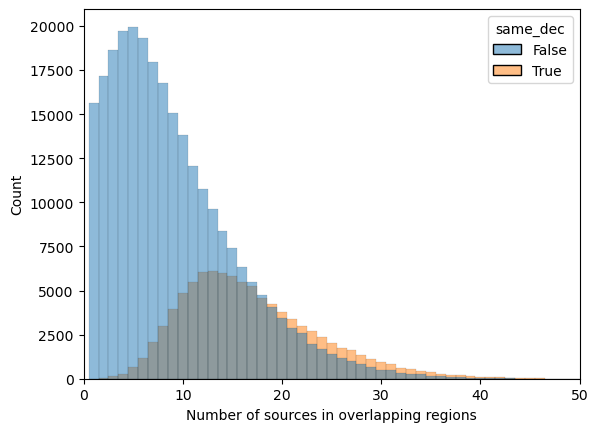

In [165]:
ax = sns.histplot(data=overlapping_fields, x='n_sources', hue='same_dec', discrete=True)
ax.set(xlabel='Number of sources in overlapping regions', xlim=(0, 50));

In [180]:
print('Same declination:')
sel = overlapping_fields['same_dec']
print(overlapping_fields.loc[sel, 'n_sources'].describe())

print('\nDifferent declination:')
print(overlapping_fields.loc[~sel, 'n_sources'].describe())

Same declination:
count    93268.000000
mean        16.839463
std          7.266756
min          1.000000
25%         12.000000
50%         16.000000
75%         21.000000
max        461.000000
Name: n_sources, dtype: float64

Different declination:
count    263253.000000
mean          9.140610
std           6.708118
min           1.000000
25%           4.000000
50%           8.000000
75%          13.000000
max         463.000000
Name: n_sources, dtype: float64


##### How many stars are in the overlapping regions depending on Galactic latitude?

In [166]:
bin_size = 2
bins = np.arange(np.ceil(overlapping_fields['field1_b'].max()), np.floor(overlapping_fields['field1_b'].min())-bin_size, -bin_size)[::-1]
bin_centers = (bins[0:-1] + bins[1:]) / 2

For field pairs in the same declination ring:

In [170]:
sel = overlapping_fields['same_dec']
counts_grouped = overlapping_fields.loc[sel].groupby(by=pd.cut(overlapping_fields.loc[sel, 'field1_b'], bins=bins))
overlapping_fields_per_b = counts_grouped.min()
overlapping_fields_per_b = overlapping_fields_per_b.reset_index(drop=True).rename(columns={'n_sources': 'n_sources_min'}).loc[:, ('n_sources_min', )]
overlapping_fields_per_b.insert(0, 'b_bin_center', bin_centers)
overlapping_fields_per_b.insert(
        2, 'n_sources_median', 
        counts_grouped.median()['n_sources'].values)
overlapping_fields_per_b.insert(
        3, 'n_sources_mean', 
        counts_grouped.mean()['n_sources'].values)
overlapping_fields_per_b.insert(
        4, 'n_sources_std', 
        counts_grouped.std()['n_sources'].values)
overlapping_fields_per_b.insert(
        5, 'n_sources_max', 
        counts_grouped.max()['n_sources'].values)

overlapping_fields_per_b

,b_bin_center,n_sources_min,n_sources_median,n_sources_mean,n_sources_std,n_sources_max
0,-63.0,4.0,12.0,12.350649,4.002520,22.0
1,-61.0,4.0,13.0,13.046392,3.906254,28.0
2,-59.0,4.0,13.0,13.525773,3.533248,26.0
3,-57.0,5.0,14.0,13.915436,3.799702,28.0
4,-55.0,4.0,14.0,13.833333,3.785164,29.0
...,...,...,...,...,...,...
72,81.0,1.0,10.0,10.172754,3.216614,25.0
73,83.0,2.0,10.0,10.083863,3.170407,20.0
74,85.0,2.0,10.0,10.219858,3.237419,25.0
75,87.0,2.0,10.0,10.265487,3.342441,20.0


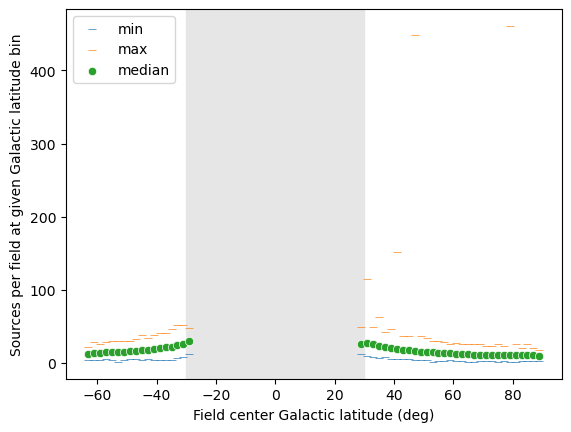

In [171]:
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per field at given Galactic latitude bin');

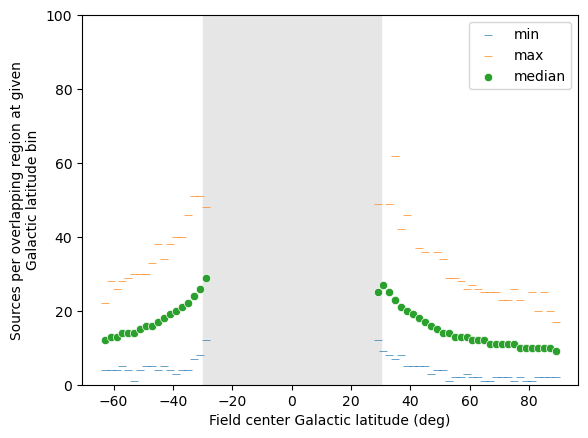

In [176]:
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per overlapping region at given\nGalactic latitude bin', ylim=(0, 100));

For field pairs *not* in the same declination ring:

In [177]:
sel = ~overlapping_fields['same_dec']
counts_grouped = overlapping_fields.loc[sel].groupby(by=pd.cut(overlapping_fields.loc[sel, 'field1_b'], bins=bins))
overlapping_fields_per_b = counts_grouped.min()
overlapping_fields_per_b = overlapping_fields_per_b.reset_index(drop=True).rename(columns={'n_sources': 'n_sources_min'}).loc[:, ('n_sources_min', )]
overlapping_fields_per_b.insert(0, 'b_bin_center', bin_centers)
overlapping_fields_per_b.insert(
        2, 'n_sources_median', 
        counts_grouped.median()['n_sources'].values)
overlapping_fields_per_b.insert(
        3, 'n_sources_mean', 
        counts_grouped.mean()['n_sources'].values)
overlapping_fields_per_b.insert(
        4, 'n_sources_std', 
        counts_grouped.std()['n_sources'].values)
overlapping_fields_per_b.insert(
        5, 'n_sources_max', 
        counts_grouped.max()['n_sources'].values)

overlapping_fields_per_b

,b_bin_center,n_sources_min,n_sources_median,n_sources_mean,n_sources_std,n_sources_max
0,-63.0,1.0,6.0,7.463203,4.799202,21.0
1,-61.0,1.0,6.0,7.464874,4.995208,26.0
2,-59.0,1.0,6.0,7.602890,5.034995,27.0
3,-57.0,1.0,6.0,7.696573,5.137127,26.0
4,-55.0,1.0,6.0,7.727790,5.193112,26.0
...,...,...,...,...,...,...
72,81.0,1.0,5.0,5.702035,3.548371,19.0
73,83.0,1.0,5.0,5.579772,3.458962,18.0
74,85.0,1.0,5.0,5.572099,3.398480,22.0
75,87.0,1.0,6.0,5.713318,3.458745,19.0


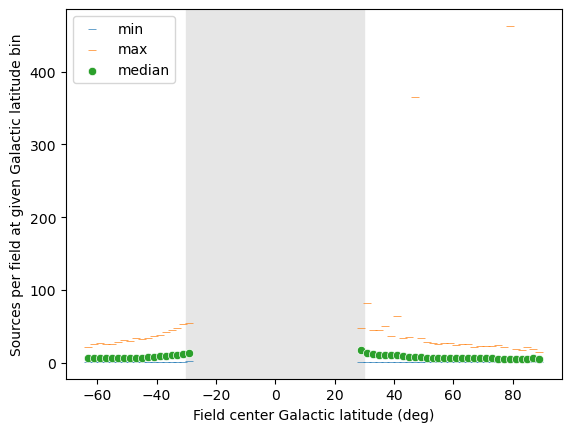

In [178]:
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per field at given Galactic latitude bin');

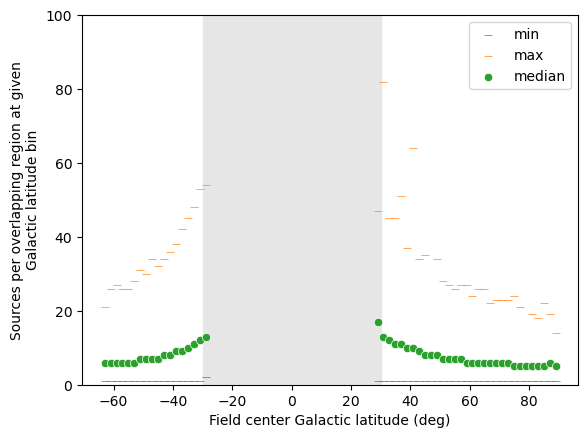

In [179]:
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_min', marker='_', label='min')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_max', marker='_', label='max')
ax = sns.scatterplot(data=overlapping_fields_per_b, x='b_bin_center', y='n_sources_median', marker='o', label='median')
ax.axvspan(-30, 30, color='0.9', zorder=0)
ax.set(xlabel='Field center Galactic latitude (deg)', ylabel='Sources per overlapping region at given\nGalactic latitude bin', ylim=(0, 100));